# Benchmarking RL methods to solve BlackJack


Thomas Lemercier & Gaspard Berthelier

## Imports

In [1]:
# from google.colab import drive
# drive.mount("/content/drive")
# %cd /content/drive/MyDrive/RL/blackjack

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/RL/blackjack


In [1]:
import gym
import time
from tqdm import tqdm
import numpy as np

In [2]:
from src.utils.general import state_to_index, get_num_states, state_to_tensor_encoding
from src.utils.data_struct import Transition
from src.agents import Agent
from src.utils.visualization import plot_policy_simple_blackjack


def play_episode(env: gym.Env, agent: Agent, render: bool = False, array_encoding: bool = False):
    """plays one episode of given agent"""
    state = env.reset()
    if render:
        env.render()
    if array_encoding:
        state = state_to_tensor_encoding(state, env.observation_space)
    else:
        state = state_to_index(state, env.observation_space)
    terminated = False
    while not terminated:
        action = agent.get_best_action(state)
        next_state, reward, terminated, _, _ = env.step(action)
        if render:
            env.render()
        if array_encoding:
            next_state = state_to_tensor_encoding(next_state, env.observation_space)
        else:
            next_state = state_to_index(next_state, env.observation_space)
        state = next_state
    return reward

In [3]:
def play_policy(env: gym.Env, agent: Agent, n_test_episodes: int,  array_encoding: bool = False):
  """test the agent's policy on multiple episodes, prints the last one"""
  rewards = [play_episode(env, agent, render= i == n_test_episodes-1, array_encoding=array_encoding) for i in range(n_test_episodes)]
  rewards = np.array(rewards)
  n_wins = np.sum(rewards == 1)
  n_draws = np.sum(rewards == 0)
  print(f"Win rate: {n_wins / n_test_episodes:.4f}")
  print(f"Draw rate: {n_draws / n_test_episodes:.4f}")

In [4]:
n_episodes = 500_000
n_test_episodes = 100_000

## Infinite Deck

Infinite deck, aka probabilities of drawing each card remains constant

In [9]:
from src.envs import InfiniteSimpleBlackjack
env = InfiniteSimpleBlackjack(seed=42)

### Random

Random agent which takes action randomly at each step

In [13]:
from src.agents import RandomAgent

agent = RandomAgent(env.action_space)
play_policy(env, agent, n_test_episodes, False)


Player's hand: [2, 6] (value: 8)
Dealer's hand: [10, 2] (value: 12)
Current state: [ 8 10  0]


Player's hand: [2, 6] (value: 8)
Dealer's hand: [10, 2, 3, 10] (value: 25)
Current state: [ 8 10  0]

Win rate: 0.2777
Draw rate: 0.0408


### Sarsa

In [9]:
from src.explorations import EpsilonGreedy, UCB
from src.utils.data_struct import SarsaParameters
from src.agents import SarsaAgent

def main_sarsa(env: gym.Env, agent: SarsaAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        action = agent.act(state)
        while not terminated:
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)
            
            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            action = agent.act(next_state)
            state = next_state
            agent.step(transition, action)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")

    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [20]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:23<00:00, 21423.17it/s]

Win rate: 0.3661
Draw rate: 0.0788

Time taken: 23.3392 seconds


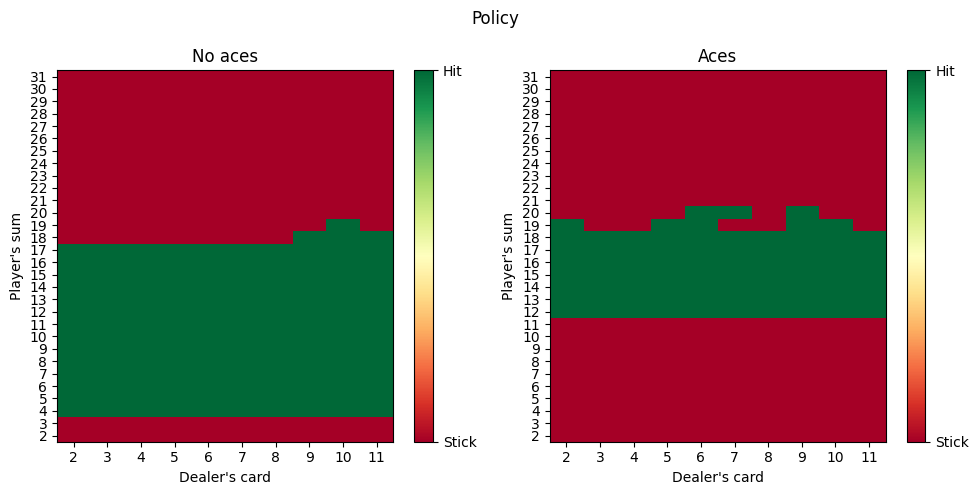


Player's hand: [10, 10] (value: 20)
Dealer's hand: [11, 4] (value: 15)
Current state: [20 11  0]


Player's hand: [10, 10] (value: 20)
Dealer's hand: [11, 4, 10, 6] (value: 21)
Current state: [20 11  0]

Win rate: 0.3615
Draw rate: 0.0796


In [21]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

play_policy(env, agent, n_test_episodes)

### Q Learning

In [23]:
from src.agents import QlearningAgent
from src.utils.data_struct import QlearningParameters

def main_qlearning(env: gym.Env, agent: QlearningAgent, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_index(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)
            next_state = state_to_index(next_state, env.observation_space)

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.4f}")
    print(f"Draw rate: {n_draws / n_episodes:.4f}")
    print(f"\nTime taken: {time.time() - start:.4f} seconds")

In [24]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:20<00:00, 24670.50it/s]

Win rate: 0.3617
Draw rate: 0.0781

Time taken: 20.2671 seconds


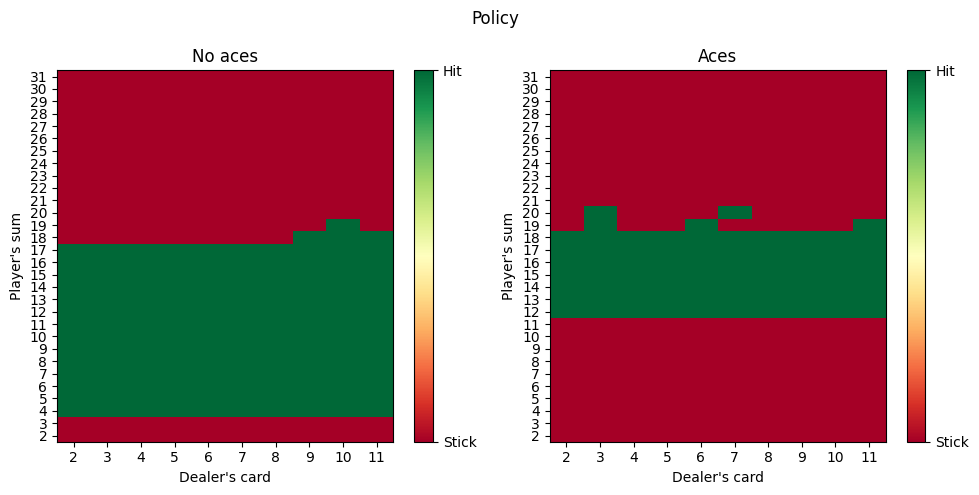


Player's hand: [9, 10] (value: 19)
Dealer's hand: [2, 3] (value: 5)
Current state: [19  2  0]


Player's hand: [9, 10] (value: 19)
Dealer's hand: [2, 3, 11, 4] (value: 20)
Current state: [19  2  0]

Win rate: 0.3654
Draw rate: 0.0795


In [25]:
policy = agent.get_policy()
plot_policy_simple_blackjack(policy, env.observation_space)

play_policy(env, agent, n_test_episodes)

## Simple Finite

In [26]:
from src.envs import SimpleBlackjack
env = SimpleBlackjack(seed=42, packs=4)

### Random

In [27]:
agent = RandomAgent(env.action_space, seed=42)
play_policy(env, agent, n_test_episodes)


Player's hand: [10, 10] (value: 20)
Dealer's hand: [8, 10] (value: 18)
Current state: [20  8  0  2]


Player's hand: [10, 10] (value: 20)
Dealer's hand: [8, 10] (value: 18)
Current state: [20  8  0  2]

Win rate: 0.2786
Draw rate: 0.0396


### Sarsa

In [28]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = SarsaParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = SarsaAgent(qlearning_parameters, exploration)

main_sarsa(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:28<00:00, 17451.37it/s]

Win rate: 0.3735
Draw rate: 0.0780

Time taken: 28.6511 seconds


In [30]:
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)


Player's hand: [10, 3] (value: 13)
Dealer's hand: [9, 2] (value: 11)
Current state: [13  9  0  2]


Player's hand: [10, 3, 10] (value: 23)
Dealer's hand: [9, 2] (value: 11)
Current state: [23  9  0  3]

Win rate: 0.3669
Draw rate: 0.0759


### Q Learning

In [31]:
exploration = UCB(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n, seed=42)
qlearning_parameters = QlearningParameters(num_states=get_num_states(env.observation_space), num_actions=env.action_space.n)
agent = QlearningAgent(qlearning_parameters, exploration)

main_qlearning(env, agent, n_episodes)

100%|██████████| 500000/500000 [00:24<00:00, 20177.77it/s]

Win rate: 0.3737
Draw rate: 0.0797

Time taken: 24.7802 seconds


In [34]:
policy = agent.get_policy()
play_policy(env, agent, n_test_episodes)


Player's hand: [10, 10] (value: 20)
Dealer's hand: [7, 4] (value: 11)
Current state: [20  7  0  2]


Player's hand: [10, 10] (value: 20)
Dealer's hand: [7, 4, 11, 10] (value: 22)
Current state: [20  7  0  2]

Win rate: 0.3754
Draw rate: 0.0812


## Complete

In [14]:
from src.envs import Blackjack
env = Blackjack(seed=42, packs=4)

### DQN

In [15]:
from src.agents.dqn import DQN
from src.utils.general import get_input_dim_encoding
import torch

def main_dqn(env: gym.Env, agent: DQN, n_episodes: int):
    start = time.time()
    n_wins = 0
    n_draws = 0
    for _ in tqdm(range(n_episodes)):
        state = env.reset()
        state = state_to_tensor_encoding(state, env.observation_space)
        terminated = False
        while not terminated:
            action = agent.act(state)
            next_state, reward, terminated, _, _ = env.step(action)

            next_state = state_to_tensor_encoding(next_state, env.observation_space)
            action = torch.Tensor([action]).long()
            reward = torch.Tensor([reward]).float()
            terminated = torch.Tensor([terminated]).float()

            transition = Transition(state=state, action=action, next_state=next_state, reward=reward, done=terminated)

            state = next_state
            agent.step(transition)

        if reward == 1:
            n_wins += 1
        elif reward == 0:
            n_draws += 1

    print(f"Win rate: {n_wins / n_episodes:.2f}")
    print(f"Draw rate: {n_draws / n_episodes:.2f}")

    print(f"\nTime taken: {time.time() - start:.2f} seconds")

In [16]:
n_episodes = 100_000

In [17]:
from src.utils.data_struct import DQNParameters
from src.networks import MLP
from src.utils.buffer import ReplayBuffer

params = DQNParameters()
q_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network = MLP(get_input_dim_encoding(env.observation_space), 64, env.action_space.n).to(params.device)
target_network.load_state_dict(q_network.state_dict())
replay_buffer = ReplayBuffer(10_000)
optimizer = torch.optim.AdamW(q_network.parameters(), lr=0.001, weight_decay=0.0001)
criterion = torch.nn.MSELoss()
exploration = EpsilonGreedy(0.3, 0.9)

agent = DQN(q_network, target_network, replay_buffer, optimizer, criterion, exploration, params)
main_dqn(env, agent, n_episodes)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [03:17<00:00, 506.91it/s]

Win rate: 0.37
Draw rate: 0.05

Time taken: 197.27 seconds


In [18]:
play_policy(env, agent, n_test_episodes, array_encoding=True)


Player's hand: [11, 8] (value: 19)
Dealer's hand: [4, 9] (value: 13)
Current state: {'dealer': 4, 'player': [11, 8]}


Player's hand: [11, 8] (value: 19)
Dealer's hand: [4, 9, 3, 10] (value: 26)
Current state: {'dealer': 4, 'player': [11, 8]}

Win rate: 0.3748
Draw rate: 0.0511
